# Exercice 2. Detection d'objets en tentant sa chance ...

Dans cette partie, nous allons générer aléatoirement une série de régions. Pour chaque région, nous envisagerons de la faire passer par le classificateur d'objets entraîné (mono- ou multi-catégories) dans l'exercice **1**. Il n'est pas nécessaire de réentraîner le réseau. Effectuez simplement une prediction de la présence ou l'absence d'un objet dans la regions.

Lors de la génération aléatoire des régions, vous pouvez demander la génération de plusieurs types de regions (rectangles debouts, carrés, rectangles couchés). Vous obtiendrez ainsi pour chaque image un ensemble de regions caractérisées par: (x<sub>i</sub>,y<sub>i</sub>,w<sub>i</sub>,h<sub>i</sub>).

**Q1** Ecrire le code de la function qui génére les regions candidates:

In [7]:
# MODEL 
# Load the model
import tensorflow as tf

model = tf.keras.models.load_model('model_multiclass.keras')
model_bin = tf.keras.models.load_model('model_binary.keras')


In [8]:
import numpy as np

def generateRegions(image, nb_regions):
    """
        Génère aléatoirement des régions candidates de différents types.
        
        Args:
            image: Image numpy array (H, W, C) ou (H, W)
            nb_regions: Nombre de régions à générer
        
        Returns:
            Liste de régions [[x0,y0,w0,h0], ..., [xnr,ynr,wnr,hnr]]
    """
    h_img, w_img = image.shape[:2]
    
    # Tailles minimales et maximales des régions
    min_size = 32
    max_size_ratio = 0.8
    
    regions = []
    
    for _ in range(nb_regions):
        # Choisir aléatoirement le type de région
        region_type = np.random.choice(['square', 'vertical', 'horizontal'])
        
        if region_type == 'square':
            # Carré
            max_side = int(min(h_img, w_img) * max_size_ratio)
            side = np.random.randint(min_size, max(min_size + 1, max_side))
            w, h = side, side
            
        elif region_type == 'vertical':
            # Rectangle debout (plus haut que large)
            max_w = int(w_img * max_size_ratio)
            max_h = int(h_img * max_size_ratio)
            w = np.random.randint(min_size, max(min_size + 1, max_w))
            # Hauteur entre 1.2x et 2x la largeur
            h_min = int(w * 1.2)
            h_max = min(int(w * 2.5), max_h)
            if h_min >= h_max:
                h = h_min
            else:
                h = np.random.randint(h_min, h_max)
            h = min(h, h_img - 1)
            
        else:
            # Rectangle couché (plus large que haut)
            max_w = int(w_img * max_size_ratio)
            max_h = int(h_img * max_size_ratio)
            h = np.random.randint(min_size, max(min_size + 1, max_h))
            # Largeur entre 1.2x et 2x la hauteur
            w_min = int(h * 1.2)
            w_max = min(int(h * 2.5), max_w)
            if w_min >= w_max:
                w = w_min
            else:
                w = np.random.randint(w_min, w_max)
            w = min(w, w_img - 1)
        
        # Générer une position valide (x, y) pour que la région reste dans l'image
        x_max = w_img - w
        y_max = h_img - h
        
        if x_max <= 0:
            x = 0
            w = w_img
        else:
            x = np.random.randint(0, x_max)
            
        if y_max <= 0:
            y = 0
            h = h_img
        else:
            y = np.random.randint(0, y_max)
        
        regions.append([x, y, w, h])
    
    return regions

Vous passerez chacune de ces regions par le réseau (de l'exercice **1**) et vous conserverez uniquement celles pour lesquelles un objet a été reconnu.

Conserver la classe et la valeur du logit correspondant qui nous servira à évaluer la confiance en la detection. Ainsi, pour chaque image vous avez une nouvelle description des regions (x<sub>i</sub>,y<sub>i</sub>,w<sub>i</sub>,h<sub>i</sub>,c<sub>i</sub>,logit<sub>i</sub>) où c<sub>i</sub> correspond à la classe et logit<sub>i</sub> au logit ayant déterminé la classe (il jouera le rôle de la confiance qu'on fait en la detection).

**Q2** Ecrire le code de la fonction qui preselectionne les régions contenant un objet potentiel:

In [9]:
import cv2

def preselectRegions(image, regions, classifier, input_size=(64, 64), background_class=0):
    """
    Présélectionne les régions contenant potentiellement un objet.
    
    Args:
        image: Image source numpy array (H, W, C)
        regions: Liste de régions [[x, y, w, h], ...]
        classifier: Modèle Keras entraîné
        input_size: Taille d'entrée du modèle (largeur, hauteur)
        background_class: Index de la classe "fond" (à exclure)
        
    Returns:
        Liste de régions avec clas  se et logit [[x, y, w, h, c, logit], ...]
    """
    selected_regions = []
    
    # Préparer les crops pour une prédiction par batch (plus efficace)
    crops = []
    valid_regions = []
    
    for region in regions:
        x, y, w, h = region
        
        # Extraire la région de l'image
        crop = image[y:y+h, x:x+w]
        
        # Vérifier que le crop n'est pas vide
        if crop.size == 0:
            continue
            
        # Redimensionner à la taille d'entrée du modèle
        crop_resized = cv2.resize(crop, input_size)
        
        # Normaliser les pixels [0, 1]
        crop_normalized = crop_resized.astype(np.float32) / 255.0
        
        crops.append(crop_normalized)
        valid_regions.append(region)
    
    if len(crops) == 0:
        return []
    
    # Convertir en batch numpy array
    batch = np.array(crops)
    
    # Prédiction sur le batch
    predictions = classifier.predict(batch, verbose=0)
    
    # Déterminer si c'est un classificateur binaire ou multiclasse
    is_binary = predictions.shape[1] == 1 or (predictions.shape[1] == 2)
    
    for i, region in enumerate(valid_regions):
        x, y, w, h = region
        
        if predictions.shape[1] == 1:
            # Classificateur binaire avec sortie sigmoïde
            logit = predictions[i, 0]
            predicted_class = 1 if logit > 0.5 else 0
            confidence = logit if predicted_class == 1 else 1 - logit
        else:
            # Classificateur multiclasse (softmax) ou binaire
            logits = predictions[i]
            predicted_class = np.argmax(logits)
            confidence = logits[predicted_class]
        
        # Conserver uniquement si ce n'est pas le fond (background)
        if predicted_class != background_class:
            selected_regions.append([x, y, w, h, predicted_class, confidence])
    
    return selected_regions

Pour les régions classées comme contenant un objet, appliquez l'algorithme de suppression des non-maxima classe par classe.

Triez les régions par ordre décroissant de score de confiance/prédiction.

Calculez l'IoU entre la première région de la liste et toutes les autres. Si l'IoU est supérieur au seuil, supprimez la région correspondante de la liste.

Répétez l'opération jusqu'à ce que toutes les régions aient été traitées ou supprimées.

**Q3** Proposez une implementation pour le calcul de l'IoU et pour l'algorithm de NonMaxSuppression

In [10]:
def IoU(regionA, regionB):
    """
    Calcule l'Intersection over Union (IoU) entre deux régions.
    
    Args:
        regionA: Région [x, y, w, h, ...] (peut contenir c et logit)
        regionB: Région [x, y, w, h, ...] (peut contenir c et logit)
        
    Returns:
        iou: Valeur IoU entre 0 et 1
    """
    # Extraire les coordonnées
    xA, yA, wA, hA = regionA[:4]
    xB, yB, wB, hB = regionB[:4]
    
    # Calculer les coordonnées des coins
    # Region A: (xA, yA) -> (xA + wA, yA + hA)
    # Region B: (xB, yB) -> (xB + wB, yB + hB)
    
    # Coordonnées de l'intersection
    x_inter_left = max(xA, xB)
    y_inter_top = max(yA, yB)
    x_inter_right = min(xA + wA, xB + wB)
    y_inter_bottom = min(yA + hA, yB + hB)
    
    # Calculer l'aire de l'intersection
    inter_width = max(0, x_inter_right - x_inter_left)
    inter_height = max(0, y_inter_bottom - y_inter_top)
    intersection_area = inter_width * inter_height
    
    # Calculer les aires des deux régions
    areaA = wA * hA
    areaB = wB * hB
    
    # Calculer l'union
    union_area = areaA + areaB - intersection_area
    
    # Éviter la division par zéro
    if union_area == 0:
        return 0.0
    
    iou = intersection_area / union_area
    return iou


def nonmaxSuppression(image, classes, regionsWithClassAndLogit, iou_threshold=0.5):
    """
    Applique l'algorithme de suppression des non-maxima classe par classe.
    
    Args:
        image: Image source (non utilisée mais gardée pour compatibilité)
        classes: Liste des classes à considérer
        regionsWithClassAndLogit: Liste de régions [[x, y, w, h, c, logit], ...]
        iou_threshold: Seuil IoU pour la suppression (défaut 0.5)
        
    Returns:
        Liste de régions après NMS [[x, y, w, h, c, logit], ...]
    """
    if len(regionsWithClassAndLogit) == 0:
        return []
    
    final_regions = []
    
    # Appliquer NMS classe par classe
    for cls in classes:
        # Filtrer les régions de cette classe
        class_regions = [r for r in regionsWithClassAndLogit if r[4] == cls]
        
        if len(class_regions) == 0:
            continue
        
        # Trier par ordre décroissant de confiance (logit)
        class_regions = sorted(class_regions, key=lambda r: r[5], reverse=True)
        
        # Liste des régions à conserver pour cette classe
        keep = []
        
        while len(class_regions) > 0:
            # Prendre la région avec le plus haut score
            best_region = class_regions.pop(0)
            keep.append(best_region)
            
            # Filtrer les régions restantes
            remaining = []
            for region in class_regions:
                # Calculer l'IoU avec la meilleure région
                iou = IoU(best_region, region)
                
                # Garder seulement si IoU < seuil
                if iou < iou_threshold:
                    remaining.append(region)
            
            class_regions = remaining
        
        final_regions.extend(keep)
    
    return final_regions

**Q4** Calculez ensuite, pour chaque région restante, l'IoU avec les boîtes englobantes consituant la vérité de terrain et gardez uniquement les fenetre avec un IoU supperieur à un seuil fixé. Parcourez les regions en fonction des leur niveau de confiance. Au fur et à mesure que les groundtruth_regions se voient attribuer une candidate_region, il faut enlever cette groundtruth_region de la liste afin d'éviter que plusieurs regions candidates soient ratachées à la même région de la groundtruth.

In [11]:
def compareToGroundTruth(image, groundtruth_regions, candidate_regions, iou_threshold=0.5):
    """
    Compare les régions candidates avec la vérité de terrain.
    
    Args:
        image: Image source (non utilisée mais gardée pour compatibilité)
        groundtruth_regions: Liste des régions GT [[x, y, w, h], ...] ou [[x, y, w, h, c], ...]
        candidate_regions: Liste des régions candidates [[x, y, w, h, c, logit], ...]
        iou_threshold: Seuil IoU pour considérer un match (défaut 0.5)
        
    Returns:
        TPRegions: Régions candidates correctement matchées avec GT (True Positives)
        FPDetected: Régions candidates non matchées (False Positives - détections incorrectes)
        FNNonDetected: Régions GT non détectées (False Negatives)
    """
    if len(candidate_regions) == 0:
        return [], [], list(groundtruth_regions)
    
    if len(groundtruth_regions) == 0:
        return [], list(candidate_regions), []
    
    # Copier la liste des GT pour pouvoir la modifier
    remaining_gt = list(groundtruth_regions)
    
    # Trier les candidates par ordre décroissant de confiance (logit)
    sorted_candidates = sorted(candidate_regions, key=lambda r: r[5], reverse=True)
    
    TPRegions = []      # True Positives
    FPDetected = []     # False Positives (détections sans correspondance GT)
    
    for candidate in sorted_candidates:
        best_iou = 0
        best_gt_idx = -1
        
        # Chercher la meilleure correspondance GT
        for idx, gt in enumerate(remaining_gt):
            iou = IoU(candidate, gt)
            
            # Vérifier aussi la classe si elle est disponible dans GT
            if len(gt) > 4 and len(candidate) > 4:
                # Si GT a une classe, vérifier qu'elle correspond
                gt_class = gt[4]
                candidate_class = candidate[4]
                if gt_class != candidate_class:
                    continue  # Classes différentes, pas de match
            
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = idx
        
        # Vérifier si l'IoU dépasse le seuil
        if best_iou >= iou_threshold and best_gt_idx >= 0:
            # True Positive : match trouvé
            TPRegions.append(candidate)
            # Retirer la GT matchée pour éviter les doubles attributions
            remaining_gt.pop(best_gt_idx)
        else:
            # False Positive : pas de correspondance GT
            FPDetected.append(candidate)
    
    # Les GT restantes sont des False Negatives (non détectées)
    FNNonDetected = remaining_gt
    
    return TPRegions, FPDetected, FNNonDetected

## Détection d'une classe d'objets

Appliquez la procédure à l'ensemble d'images contenant l'étiquette 4 (Éléphant). 
Nous ne découperons plus par rapport à l'éléphant, mais considérons l'image dans son ensemble. 
Dans cette situation, nous considérons que tout autre objet apparaîssant sur les images que l'éléphant fait partie de l'arrière plan. 
Lors du chargement des données, uniquement les regions concernant l'éléphant feront partie de la vérité de terrain.

Utilisez un classifier binaire capable de reconnaître un éléphant.

Vous devez coder une nouvelle version de la fonction `load_elephant_objects` afin de prendre en compte ces considérations.

**Q5** Coder `load_elephant_objects`

In [ ]:
import os
import csv
import math

train_path = "../toy-dataset/train/"
test_path = "../toy-dataset/test/"

ELEPHANT_CLASS = 4

def load_elephant_objects(imgs_path=test_path):
    """
    Charge les images contenant des éléphants avec leurs boîtes englobantes.
    
    Seules les régions correspondant à des éléphants (classe 4) font partie 
    de la vérité de terrain. Les autres objets sont considérés comme arrière-plan.
    
    Args:
        imgs_path: Chemin vers le dossier contenant images/ et labels/
        
    Returns:
        x: Liste d'images contenant des éléphants [img1, img2, ...]
        y: Liste de listes de boîtes englobantes [[r11, r12], [r21], ...]
           où rij = [xij, yij, wij, hij] en coordonnées absolues (pixels)
    """
    x = []  # Images
    y = []  # Boîtes englobantes par image
    
    imgs_files = os.listdir(imgs_path + "images/")
    
    for img_file in imgs_files:
        label_file = img_file[:-4] + ".txt"
        label_path = imgs_path + "labels/" + label_file
        
        # Vérifier que le fichier label existe
        if not os.path.exists(label_path):
            continue
            
        # Lire l'image
        img = cv2.imread(imgs_path + "images/" + img_file)
        if img is None:
            continue
            
        img_height, img_width = img.shape[:2]
        
        # Lire les labels
        labels = csv.reader(open(label_path, "r"), delimiter=' ')
        rows = list(labels)
        
        # Collecter les boîtes englobantes des éléphants dans cette image
        elephant_boxes = []
        
        for row in rows:
            if len(row) < 5:
                continue
                
            categ = int(row[0])
            
            # Ne garder que les éléphants (classe 4)
            if categ != ELEPHANT_CLASS:
                continue
            
            # Convertir du format YOLO (cx, cy, w, h normalisés) 
            # vers format absolu (x, y, w, h en pixels)
            cx = float(row[1])
            cy = float(row[2])
            w_norm = float(row[3])
            h_norm = float(row[4])
            
            # Convertir en pixels
            w = int(w_norm * img_width)
            h = int(h_norm * img_height)
            x0 = max(0, int(cx * img_width - w / 2))
            y0 = max(0, int(cy * img_height - h / 2))
            
            # S'assurer que la boîte reste dans l'image
            x0 = min(x0, img_width - 1)
            y0 = min(y0, img_height - 1)
            w = min(w, img_width - x0)
            h = min(h, img_height - y0)
            
            elephant_boxes.append([x0, y0, w, h])
        
        # N'ajouter l'image que si elle contient au moins un éléphant
        if len(elephant_boxes) > 0:
            x.append(img)
            y.append(elephant_boxes)
    
    return x, y

In [16]:
X, y = load_elephant_objects()

**Q6** Pour chaque image du test set affichez le nombre de TP, FP, TN.
Choissisez un sous-ensemble de 3 images sur lesquelles vous superposer en vert la GT, en blue les TP, en orange les FP et en rouge les FN.

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Charger les images contenant des éléphants
x_test, y_test = load_elephant_objects(test_path)

print(f"Nombre d'images avec éléphants dans le test set: {len(x_test)}")

# Paramètres
NB_REGIONS = 500  # Nombre de régions candidates à générer
IOU_THRESHOLD_NMS = 0.3  # Seuil IoU pour NMS
IOU_THRESHOLD_GT = 0.5   # Seuil IoU pour comparaison avec GT
INPUT_SIZE = (128, 128)  # Taille d'entrée du modèle (doit correspondre à l'entraînement)

# Classes pour NMS (classe 1 = éléphant dans le classificateur binaire)
classes = [1]

# Stocker les résultats pour chaque image
results = []

print("\nÉvaluation par image:")
print("-" * 50)

for i, (image, gt_boxes) in enumerate(zip(x_test, y_test)):
    # 1. Générer des régions candidates
    regions = generateRegions(image, NB_REGIONS)
    
    # 2. Présélectionner les régions avec le classificateur binaire
    preselected = preselectRegions(image, regions, model_bin, input_size=INPUT_SIZE, background_class=0)
    
    # 3. Appliquer NMS
    nms_regions = nonmaxSuppression(image, classes, preselected, iou_threshold=IOU_THRESHOLD_NMS)
    
    # 4. Comparer avec la vérité de terrain
    TP, FP, FN = compareToGroundTruth(image, gt_boxes, nms_regions, iou_threshold=IOU_THRESHOLD_GT)
    
    # Stocker les résultats
    results.append({
        'image': image,
        'gt_boxes': gt_boxes,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'nms_regions': nms_regions
    })
    
    print(f"Image {i+1}: TP={len(TP)}, FP={len(FP)}, FN={len(FN)} (GT={len(gt_boxes)})")

# Résumé global
total_TP = sum(len(r['TP']) for r in results)
total_FP = sum(len(r['FP']) for r in results)
total_FN = sum(len(r['FN']) for r in results)

print("-" * 50)
print(f"TOTAL: TP={total_TP}, FP={total_FP}, FN={total_FN}")

# Calcul de la précision et du rappel
precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
print(f"Précision: {precision:.3f}")
print(f"Rappel: {recall:.3f}")

Nombre d'images avec éléphants dans le test set: 30

Évaluation par image:
--------------------------------------------------
Image 1: TP=0, FP=44, FN=1 (GT=1)
Image 2: TP=1, FP=25, FN=0 (GT=1)
Image 3: TP=0, FP=35, FN=1 (GT=1)
Image 4: TP=0, FP=21, FN=1 (GT=1)
Image 5: TP=0, FP=42, FN=1 (GT=1)
Image 6: TP=0, FP=34, FN=1 (GT=1)
Image 7: TP=0, FP=31, FN=1 (GT=1)
Image 8: TP=0, FP=36, FN=1 (GT=1)
Image 9: TP=0, FP=37, FN=1 (GT=1)
Image 10: TP=1, FP=28, FN=0 (GT=1)
Image 11: TP=0, FP=38, FN=1 (GT=1)
Image 12: TP=0, FP=29, FN=1 (GT=1)
Image 13: TP=1, FP=37, FN=0 (GT=1)
Image 14: TP=0, FP=32, FN=1 (GT=1)
Image 15: TP=1, FP=25, FN=0 (GT=1)
Image 16: TP=0, FP=31, FN=1 (GT=1)
Image 17: TP=0, FP=26, FN=1 (GT=1)
Image 18: TP=0, FP=26, FN=1 (GT=1)
Image 19: TP=1, FP=40, FN=0 (GT=1)
Image 20: TP=1, FP=33, FN=0 (GT=1)
Image 21: TP=0, FP=43, FN=1 (GT=1)
Image 22: TP=1, FP=35, FN=0 (GT=1)
Image 23: TP=0, FP=30, FN=1 (GT=1)
Image 24: TP=0, FP=29, FN=1 (GT=1)
Image 25: TP=0, FP=43, FN=1 (GT=1)
Image 26

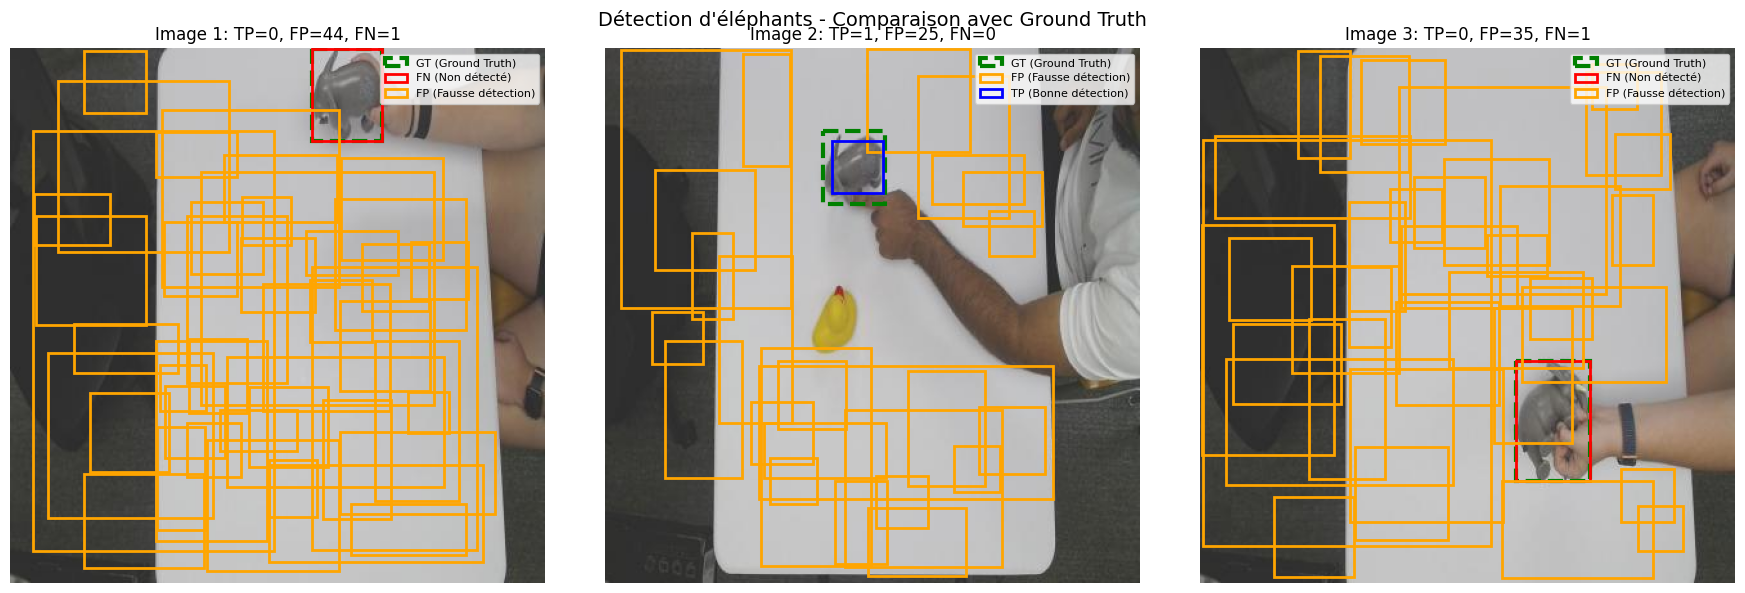


Légende:
 Vert (pointillé): Ground Truth (vérité de terrain)
 Bleu: True Positive (détection correcte)
 Orange: False Positive (fausse détection)
 Rouge: False Negative (objet non détecté)


In [22]:
# Visualisation de 3 images avec les boîtes englobantes colorées
# Vert: GT, Bleu: TP, Orange: FP, Rouge: FN

def draw_boxes(ax, boxes, color, label, linewidth=2, linestyle='-'):
    """Dessine des boîtes englobantes sur l'axe matplotlib."""
    for idx, box in enumerate(boxes):
        x, y, w, h = box[:4]
        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=linewidth,
            edgecolor=color,
            facecolor='none',
            linestyle=linestyle,
            label=label if idx == 0 else ""
        )
        ax.add_patch(rect)

# Sélectionner 3 images (on prend des images avec des résultats variés si possible)
# Choisir des images qui ont des TP, FP ou FN pour une visualisation intéressante
selected_indices = []

# Essayer de trouver des images avec différents cas
for i, r in enumerate(results):
    if len(r['TP']) > 0 and len(selected_indices) < 3:
        selected_indices.append(i)
    elif len(r['FP']) > 0 and len(selected_indices) < 3 and i not in selected_indices:
        selected_indices.append(i)
    elif len(r['FN']) > 0 and len(selected_indices) < 3 and i not in selected_indices:
        selected_indices.append(i)

# Compléter si nécessaire
while len(selected_indices) < 3 and len(selected_indices) < len(results):
    for i in range(len(results)):
        if i not in selected_indices:
            selected_indices.append(i)
            break

# Créer la figure
fig, axes = plt.subplots(1, min(3, len(selected_indices)), figsize=(18, 6))
if len(selected_indices) == 1:
    axes = [axes]

for ax_idx, img_idx in enumerate(selected_indices[:3]):
    r = results[img_idx]
    ax = axes[ax_idx]
    
    # Convertir BGR (OpenCV) vers RGB (matplotlib)
    img_rgb = cv2.cvtColor(r['image'], cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    
    # Dessiner les boîtes dans l'ordre: GT (fond), puis FN, FP, TP (dessus)
    # GT en vert (trait pointillé pour ne pas cacher les autres)
    draw_boxes(ax, r['gt_boxes'], 'green', 'GT (Ground Truth)', linewidth=3, linestyle='--')
    
    # FN en rouge (objets non détectés)
    draw_boxes(ax, r['FN'], 'red', 'FN (Non détecté)', linewidth=2)
    
    # FP en orange (fausses détections)
    draw_boxes(ax, r['FP'], 'orange', 'FP (Fausse détection)', linewidth=2)
    
    # TP en bleu (bonnes détections)
    draw_boxes(ax, r['TP'], 'blue', 'TP (Bonne détection)', linewidth=2)
    
    ax.set_title(f"Image {img_idx + 1}: TP={len(r['TP'])}, FP={len(r['FP'])}, FN={len(r['FN'])}")
    ax.axis('off')
    ax.legend(loc='upper right', fontsize=8)

plt.suptitle("Détection d'éléphants - Comparaison avec Ground Truth", fontsize=14)
plt.tight_layout()
plt.show()

# Légende explicative
print("\nLégende:")
print(" Vert (pointillé): Ground Truth (vérité de terrain)")
print(" Bleu: True Positive (détection correcte)")
print(" Orange: False Positive (fausse détection)")
print(" Rouge: False Negative (objet non détecté)")

**Q7** Calculez la précision moyenne (AP) pour les images relevant de cette étiquette sur le test set pour un IoU de 0.5.

Afin de calculer la précision moyenne, il est nécessaire de traiter l'ensemble des detections dans leur globalité par rapport à leur niveau de confiance.

Regroupez dans une liste l'ensemble de regions candidates issues de **Q4** tout en conservant une information relative à leur appartenance aux ensembles TPregions ou FPregions. Triez cette liste en fonction de niveau de confiance et parcourez la de manière décroissante.

Initialement le rappel est à zero car TP=0, FP=0 et FN=#total regions issues de la **Q4**
Au fur et à mesure qu'on traite des regions de la liste on met à jour les valeurs cumulées TP et FP pour calculer la précion et le rappel à chaque nouvelle detection.

Tracez un graphique des points (précision, rappel) intermediaires.

Vous pouvez utiliser la fonction `sklearn.metrics.auc` pour calculer la valeur d'AUC en fournissant les listes avec les valeurs intermediaires de (précision et rappel).

## Détection de plusieurs classes

Appliquez la procédure à l'ensemble d'images du dataset. 
Lors du chargement des données, l'ensemble des regions concernant des objets feront partie de la vérité de terrain. Cette fois-ci l'on gardera également des informations sur la classe spécifique associée à une boîte englobante.

**Q7** Vous devez coder une nouvelle version de la fonction `load_objects` afin de prendre en compte ces considérations.

In [1]:
def load_elephant_objects():
    ...
    return x,y #x ensemble d'images contenant des éléphants, y ensemble de positions des boîtes englobantes
    #attention x=[img1,img1,img1,...], y=[[r11,r12],[r21],[r21,r22,r23],...] 
    #si l'img1 contient deux objets situés à r11 et r12
    #si l'img2 contient un seul objet
    #si l'img3 contient trois objets
    #rij = [xij,yij,wij,hij,cij] où cij correspond à la classe de l'objet

**Q8** Calculez la précision moyenne (AP) pour l'ensemble de données pour un IoU de 0.5.
Par rapport au cas mono-classe, il est d'usage de calculer l'AUC classe par classe (et donc considerer les régions classe par classe) avant de calculer une moyenne qui tient compte de nombre d'instance de chaque classe.


**Q9** (optionnel) Pour guider mieux le processus de génération de regions candidates, vous pouvez également orienter le processus aléatoire en considérant les régions de l'image où se trouvent beaucoup de points caractéristiques (Harris, SIFTs, etc.).
Est-ce que cela améliore les résultats ?
